## GRU (Gated Recurrent Unit)

In [17]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/TCQ_DemandSum_DST.csv')
df['Actual'] = df['Sum of DST']
print(df)

       Year  Month  Day  Period  Sum of Demand_Sum   Sum of DST  Sum of TCQ  \
0      2023   July    1       1               6120  5633.853332  486.146668   
1      2023   July    1       2               6020  5554.891608  465.108392   
2      2023   July    1       3               5911  5462.731620  448.268380   
3      2023   July    1       4               5843  5408.646667  434.353333   
4      2023   July    1       5               5798  5375.573341  422.426659   
...     ...    ...  ...     ...                ...          ...         ...   
12331  2024  March   13      44               6617  6094.329111  522.670889   
12332  2024  March   13      45               6468  5975.891026  492.108974   
12333  2024  March   13      46               6333  5844.349746  488.650254   
12334  2024  March   13      47               6198  5762.694101  435.305899   
12335  2024  March   13      48               6048  5653.727449  394.272551   

            Actual  
0      5633.853332  
1      55

In [9]:
import matplotlib.pyplot as plt

# Convert month names to numeric representation
month_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
              'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df['Month'] = df['Month'].map(month_dict)

# Combine year, month, day and period to form datetime
df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) + pd.to_timedelta((df['Period'] - 1) * 30, unit='minutes')

# Set datetime column as the index
df.set_index('datetime', inplace=True)

In [11]:
from sklearn.preprocessing import StandardScaler

# Define sequence length
sequence_length = 5  # Define the length of each sequence

# Extract "Actual" column to form single feature seqeunce
demand_seq = df['Actual'].values

# Scale the values
scaler = StandardScaler()
scaled_demand_seq = scaler.fit_transform(demand_seq.reshape(-1, 1))

# Retain the mean and standard deviation of the original data
mean_of_original_data = scaler.mean_
std_dev_of_original_data = scaler.scale_

# Initialize lists to store input sequences and corresponding labels
input_sequences = []
labels = []

# Create overlapping sequences of length sequence_length
for i in range(len(scaled_demand_seq) - sequence_length):
    # Extract a sequence of length sequence_length
    sequence = scaled_demand_seq[i : i + sequence_length]
    # Append the sequence to the input_sequences list
    input_sequences.append(sequence)
    # Append the next value (label) after the sequence to the labels list
    labels.append(scaled_demand_seq[i + sequence_length])

# Convert the lists to numpy arrays
input_sequences = np.array(input_sequences)
labels = np.array(labels)

# Print the shapes of input_sequences and labels
print("Input sequences shape:", input_sequences.shape)
print("Labels shape:", labels.shape)

Input sequences shape: (12331, 5, 1)
Labels shape: (12331, 1)


In [12]:
# Splitting into train test set
from sklearn.model_selection import train_test_split

# Splitting into train and test sets. Set shuffle = False to preserve temporal order of the data
X_train, X_test, y_train, y_test = train_test_split(input_sequences, labels, test_size=0.2, shuffle=False)

# For validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

print("Shape of train_X:", X_train.shape)
print("Shape of test_X: ", X_test.shape)


In [13]:
import tensorflow as tf

# Define the GRU model
model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=64, input_shape=(sequence_length, 1)),
    tf.keras.layers.Dense(units=1)  # Output layer for regression
])

# Compile the model with RMSE as the evaluation metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/Users/matthew/Desktop/SDC_Demand_Forecast/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - RootMeanSquaredError: 0.4968 - loss: 0.2715 - val_RootMeanSquaredError: 0.1335 - val_loss: 0.0179
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1355 - loss: 0.0184 - val_RootMeanSquaredError: 0.1202 - val_loss: 0.0145
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.1140 - loss: 0.0130 - val_RootMeanSquaredError: 0.1011 - val_loss: 0.0102
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.1008 - loss: 0.0102 - val_RootMeanSquaredError: 0.0952 - val_loss: 0.0091
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.0906 - loss: 0.0082 - val_RootMeanSquaredError: 0.0921 - val_loss: 0.0085
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - RootMeanSquaredError: 0.0870 - loss: 0.0076 - val_RootMeanSquaredError: 0.0879 - val_loss: 0.0077
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.0842 - loss: 0.0071 -

In [14]:
# Evaluation
# Evaluate the model on test data
loss, rmse = model.evaluate(X_test, y_test)
print("Test RMSE:", rmse)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - RootMeanSquaredError: 0.1061 - loss: 0.0114
Test RMSE: 0.12470176815986633


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


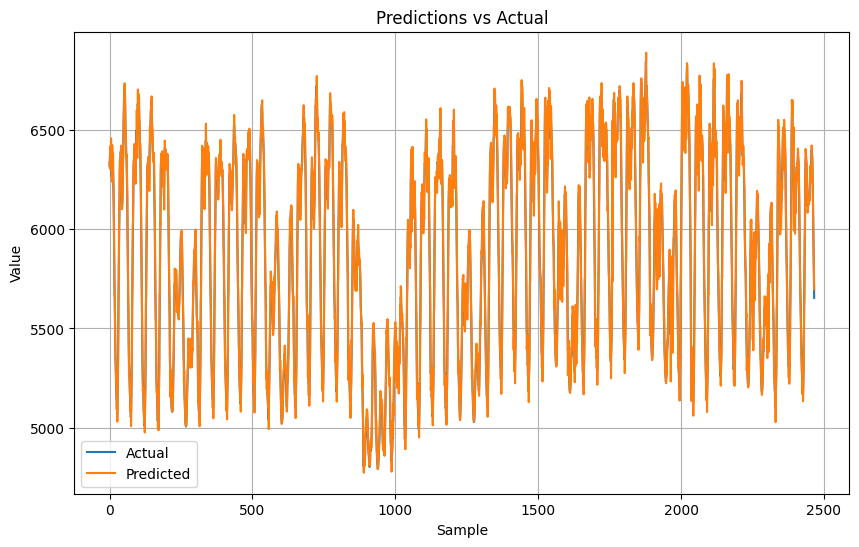

In [15]:
# Generate predictions on the test data
predictions = model.predict(X_test)

original_predictions = (predictions * std_dev_of_original_data) + mean_of_original_data
original_actual = (y_test * std_dev_of_original_data) + mean_of_original_data


# Plot predictions versus actual values
plt.figure(figsize=(10, 6))
plt.plot(original_actual, label='Actual')
plt.plot(original_predictions, label='Predicted')
plt.title('Predictions vs Actual')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Create a DataFrame to display actual vs predicted values
output_df = pd.DataFrame({'Actual': original_actual.flatten(), 'Predicted': original_predictions.flatten()})

# Print the DataFrame
print(output_df)

           Actual    Predicted
0     6318.376222  6337.627336
1     6364.408185  6303.137353
2     6349.689215  6417.049813
3     6352.115703  6324.628733
4     6408.203094  6359.463865
...           ...          ...
2462  6094.329111  6160.479985
2463  5975.891026  6005.378838
2464  5844.349746  5888.328121
2465  5762.694101  5736.807639
2466  5653.727449  5696.957248

[2467 rows x 2 columns]
